In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plotter_lib

pin_memory=False 

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset

torch.autograd.set_detect_anomaly(True)

In [2]:
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

True
NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Define the data transforms to be applied to the images
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        
        # create a list of image paths and labels for the specified mode (train or test)
        self.image_paths = []
        self.labels = []
        class_names = ['DME', 'DRUSEN']
        class_labels = [1, 0]
        for i, class_name in enumerate(class_names):
            class_path = os.path.join(self.root_dir, self.mode, class_name)
            class_label = class_labels[i]
            
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(class_label)
                    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        image_high = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image_high = self.transform(image_high)
            
        image_low = transforms.Resize(size=32)(image_high)
        
            
        return image_low, image_high, label

In [5]:
main_dir='/home/david/Documents/GitHub/ML-Biomed/midterm/Data/'

#loading all images from the train and test directories
image_datasets = {
    'train': CustomDataset(root_dir=main_dir, transform=train_transform, mode='train'),
    'test': CustomDataset(root_dir=main_dir, transform=test_transform, mode = 'test')
}

#loading train and test images using DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=os.cpu_count()),    
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=os.cpu_count())
}

# Get image and label from test data loader
image_low, image_high, labels = next(iter(dataloaders['train']))

# Print the shape of the image tensor and label tensor
#print(f"Image shape: {images.shape} -> [batch_size, color_channels, height, width]")
#print(f"Label shape: {labels.shape}")

print(f"Number of images in train set: {len(image_datasets['train'])}")
print(f"Number of images in test set: {len(image_datasets['test'])}")

Number of images in train set: 19112
Number of images in test set: 930


In [6]:
print(image_low.shape)
print(image_high.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 128, 128])


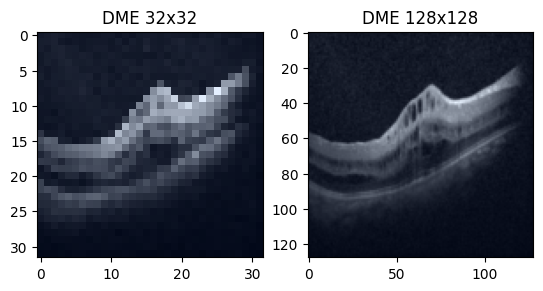

In [7]:
import matplotlib.pyplot as plt

# Define the labels
definitions = {0:"DRUSEN", 1:"DME"}

# Get one sample from the training set
sample_low, sample_high, label = image_datasets['train'][0]

# Convert the images to numpy arrays and permute the dimensions
sample_low = np.array(sample_low.permute(1, 2, 0))
sample_high = np.array(sample_high.permute(1, 2, 0))

# Normalize the pixel values to the range [0, 1] for visualization
sample_low = (sample_low - sample_low.min()) / (sample_low.max() - sample_low.min())
sample_high = (sample_high - sample_high.min()) / (sample_high.max() - sample_high.min())

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(sample_low)
axes[0].set_title(f"{definitions[label]} 32x32")
axes[1].imshow(sample_high)
axes[1].set_title(f"{definitions[label]} 128x128")
plt.show()


In [8]:
def visualize_images(lr_image, hr_image, generated_image, label, epoch, pretrain, show=False):
    # Move the tensors to the CPU and detach the generated_image tensor
    lr_image = lr_image.cpu().detach().permute(1, 2, 0).numpy()
    hr_image = hr_image.cpu().detach().permute(1, 2, 0).numpy()
    generated_image = generated_image.cpu().detach().permute(1, 2, 0).numpy()

    # Normalize the pixel values to the range [0, 1] for visualization
    lr_image = (lr_image - lr_image.min()) / (lr_image.max() - lr_image.min())
    hr_image = (hr_image - hr_image.min()) / (hr_image.max() - hr_image.min())
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(lr_image)
    axes[0].set_title("Low Resolution")
    axes[1].imshow(hr_image)
    axes[1].set_title("High Resolution")
    axes[2].imshow(generated_image)
    axes[2].set_title("Generated Image")

    # Add a common title to the figure
    if pretrain:
        fig.suptitle(f"Pre-Training - Epoch {epoch} - {label}")
    else:
        fig.suptitle(f"Epoch {epoch} - {label}")
    
    # Create the 'output' directory if it doesn't exist
    if not os.path.exists('./output'):
        os.makedirs('./output')
    
    # Save and show the figure every 5 epochs
    if epoch % 5 == 0:
        fig.savefig(f"./output/epoch_{epoch}_{label}.png")
        plt.show()
    else:
        plt.close(fig)


In [9]:
class Residual(nn.Module):
    def __init__(self, num_channels, stride=1):
        super().__init__()
        self.num_channels = num_channels
        
        self.body = nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d()
        )
        
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        
        out = self.body(x)
        
        if self.num_channels != x.shape[1]:
            x = self.conv3(x)
        else:
            self.conv3 = None
            
        out += x 
        
        return out

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        out = self.generator(x)

        return out


In [11]:
generator = Generator().to(device)
test_input = torch.rand(1,3,32,32).to(device)
print(generator(test_input).shape)

/home/david/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 3, 128, 128])


In [12]:
class PretrainGeneratorLoss(nn.Module):
    def __init__(self):
        super(PretrainGeneratorLoss, self).__init__()
        self.pre_train = True
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr):
        # Calculate the MSE loss between the super-resolved image and the high-resolution image
        content_loss = self.mse_loss(sr, hr)
        return content_loss
    
class GeneratorLoss(nn.Module):
    def __init__(self, content_weight=1e-3, adversarial_weight=1):
        super(GeneratorLoss, self).__init__()
        self.pre_train = False
        self.content_weight = content_weight
        self.adversarial_weight = adversarial_weight
        
        self.vgg19 = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')
        self.vgg19 = nn.Sequential(*list(self.vgg19.features.children())[:35])
        self.vgg19 = self.vgg19.cuda() if torch.cuda.is_available() else self.vgg19
        self.vgg19.eval()
        
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, sr, hr, discriminator_pred):
        # Calculate the content loss
        hr_features = self.vgg19(hr)
        sr_features = self.vgg19(sr)
        content_loss = self.mse_loss(sr_features, hr_features.detach())

        # Calculate the adversarial loss
        real_label = torch.ones(discriminator_pred.size())
        real_label = real_label.cuda() if torch.cuda.is_available() else real_label
        adversarial_loss = self.bce_loss(discriminator_pred, real_label)

        # Total generator loss
        total_loss = self.content_weight * content_loss + self.adversarial_weight * adversarial_loss
        return total_loss
    

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(64, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2)
        )
            
       

        # Add the fully connected part before the final nn.Linear layer
        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # Pass the output through the discriminator blocks (body)
        x = self.body(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass the output through the fully connected part
        x = self.fc(x)

        return x

In [14]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, real_pred, fake_pred):
        real_label = torch.ones(real_pred.size())
        fake_label = torch.zeros(fake_pred.size())

        if torch.cuda.is_available():
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()

        # Loss for real high-resolution images
        real_loss = self.bce_loss(real_pred, real_label)

        # Loss for generated high-resolution images
        fake_loss = self.bce_loss(fake_pred, fake_label)

        # Total discriminator loss
        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [15]:
discriminator = Discriminator().to(device)
test_input = torch.rand(1,3,128,128).to(device)
print(discriminator(test_input).shape)

torch.Size([1, 1])


In [16]:
# Create the 'models' directory if it doesn't exist
if not os.path.exists('./models'):
    os.makedirs('./models')

In [17]:
# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of epochs and the batch size
num_epochs = 100 # 50 epochs of pretraining + 100 of both = 150 total epochs
batch_size = 48
lr = 0.0001
bar_width=150

# Define the loss functions
pretrain_generator_loss = PretrainGeneratorLoss().to(device)
generator_loss_fn = GeneratorLoss().to(device)
discriminator_loss_fn = DiscriminatorLoss().to(device)

# Move the model parameters to the device
generator.to(device)
discriminator.to(device)

# Define the optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']

pretrain_loss = []
generator_loss_history = []
discriminator_loss_history = []

Starting pre-training phase...


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.24it/s, Gen loss=0.0338]


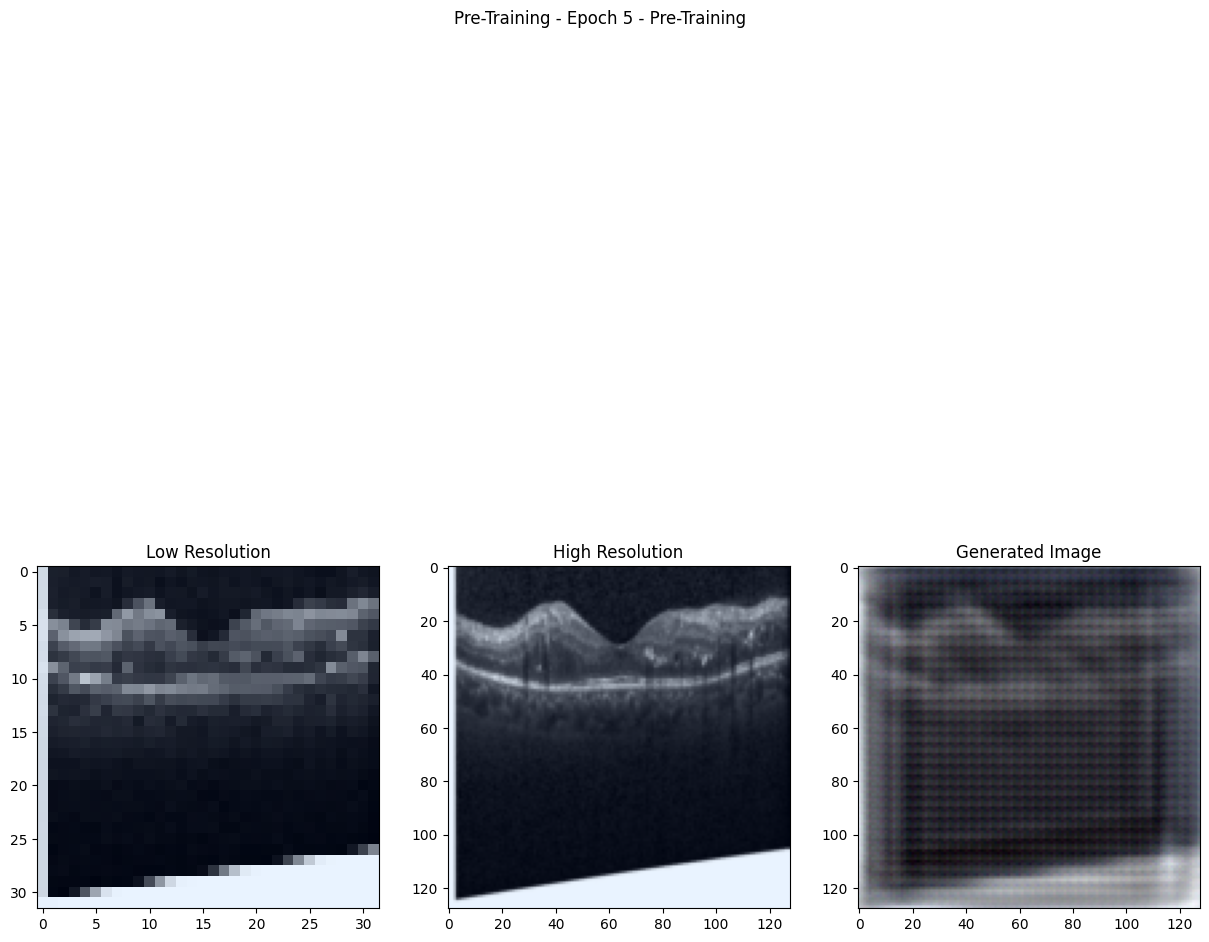

Epoch 10/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.24it/s, Gen loss=0.0290]


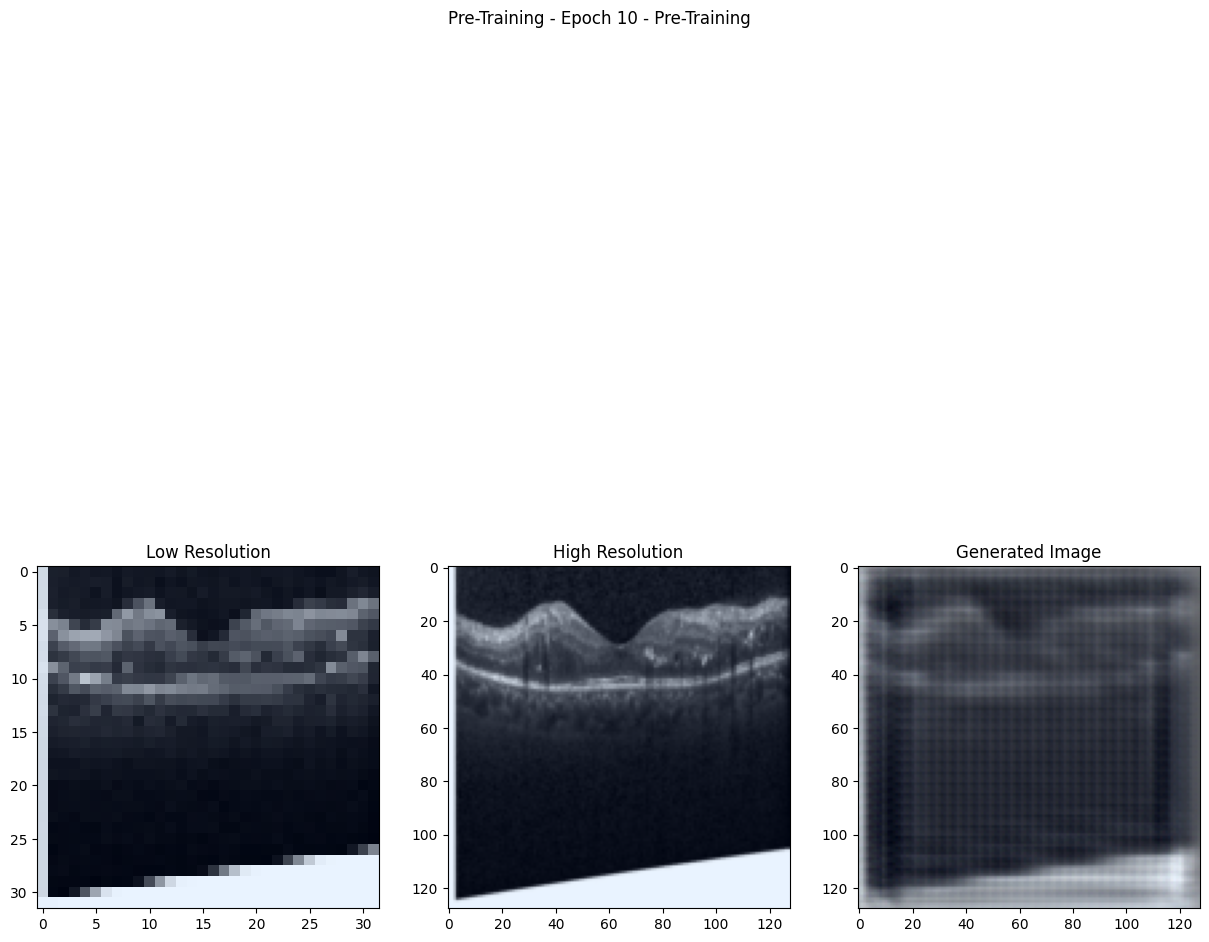

Epoch 15/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.21it/s, Gen loss=0.0251]


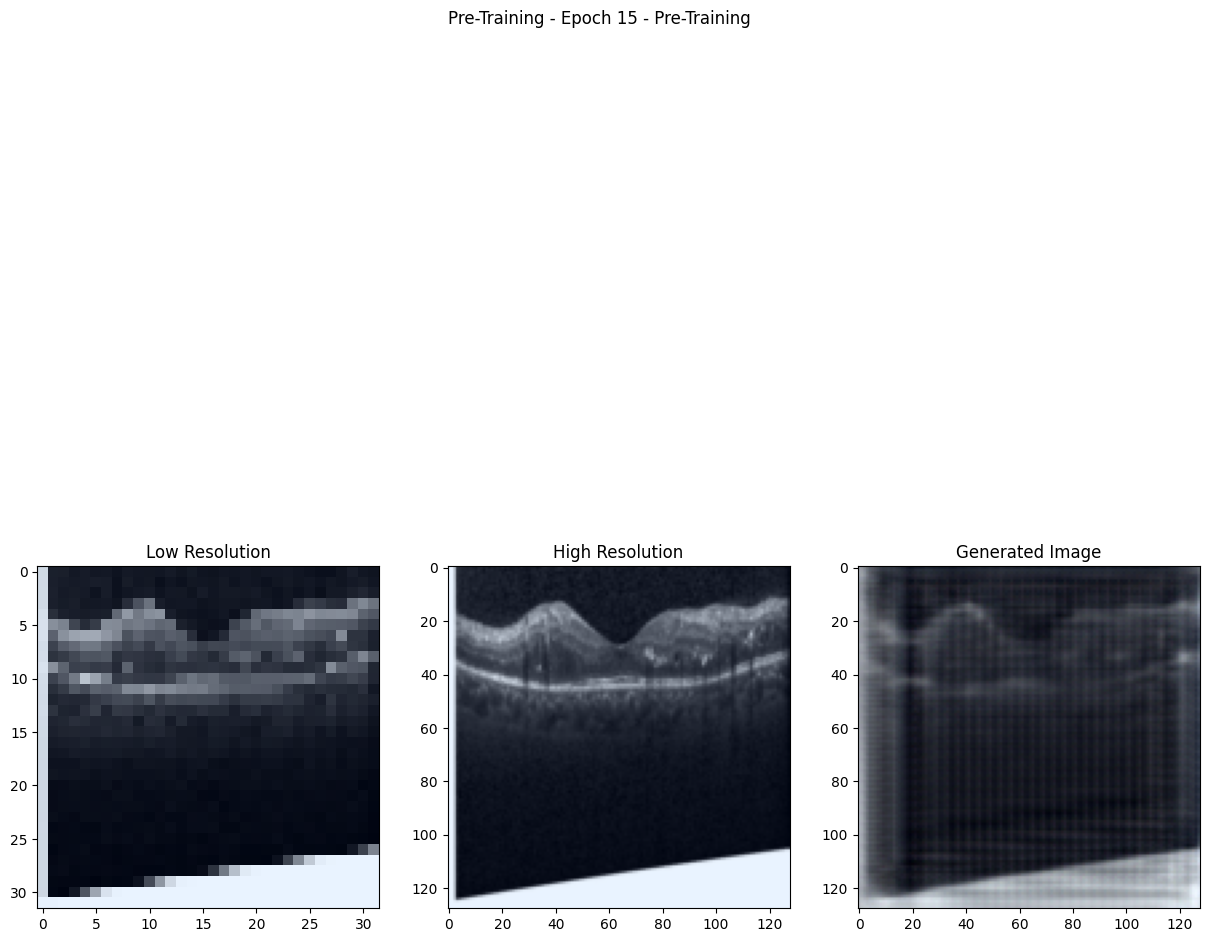

Epoch 20/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.20it/s, Gen loss=0.0257]


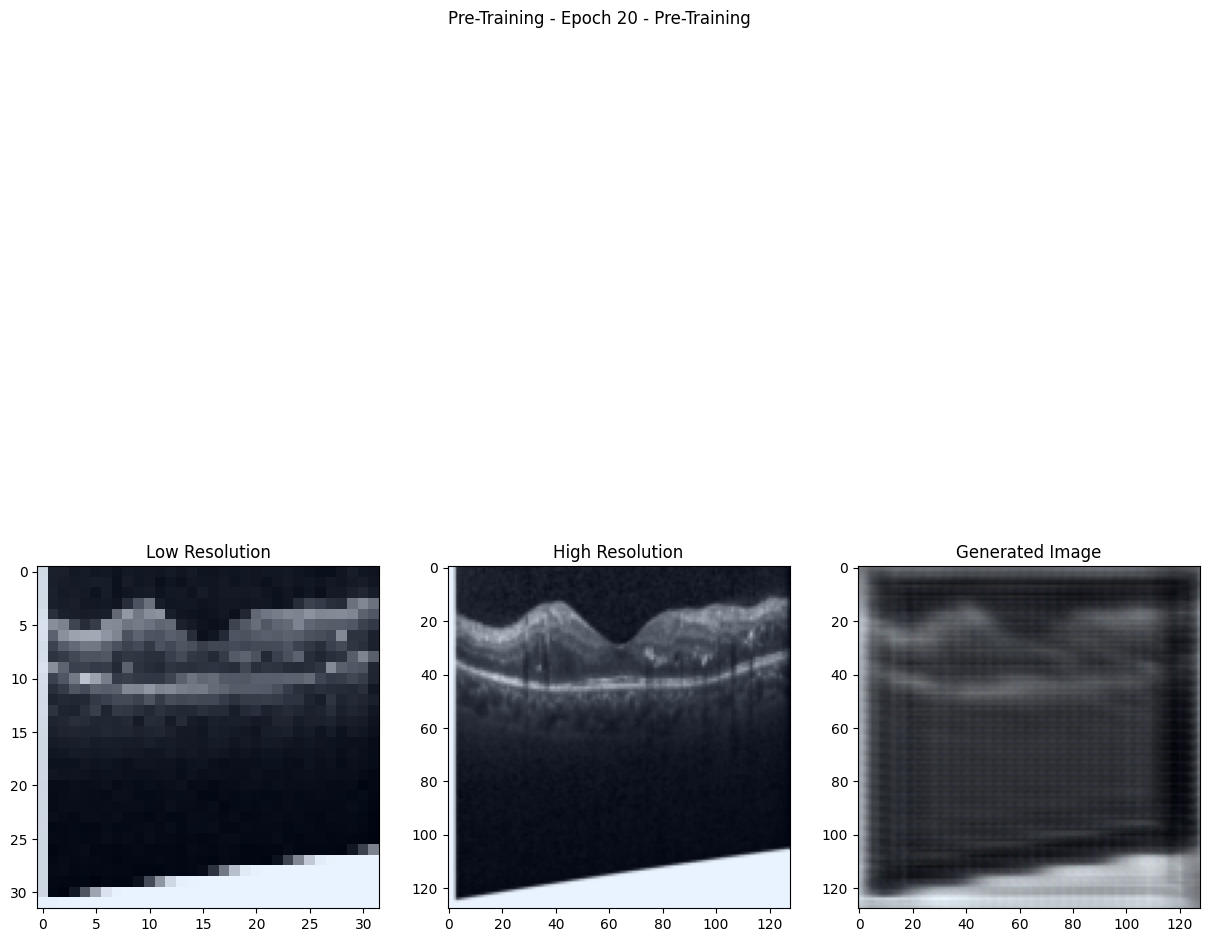

Epoch 25/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.20it/s, Gen loss=0.0230]


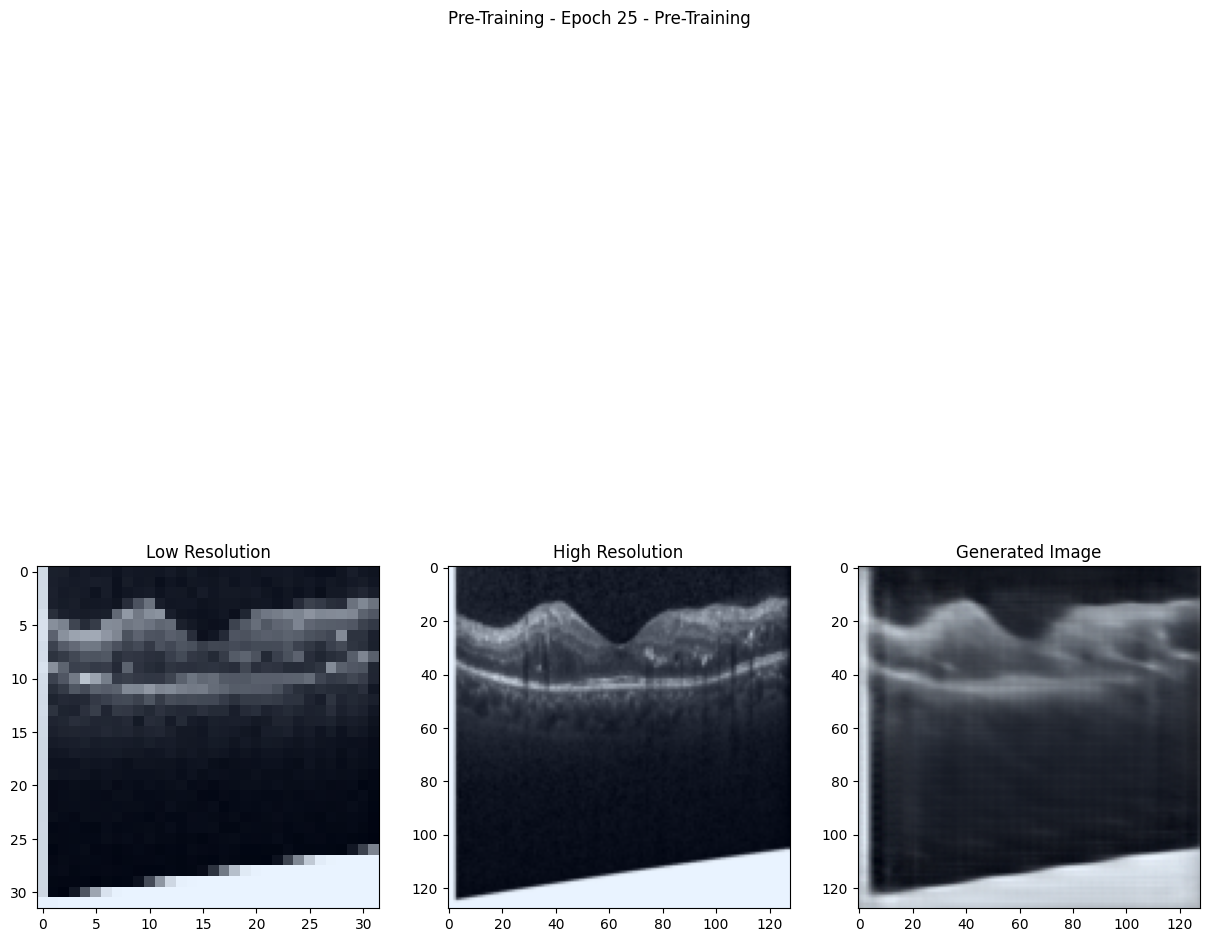

Epoch 30/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.21it/s, Gen loss=0.0257]


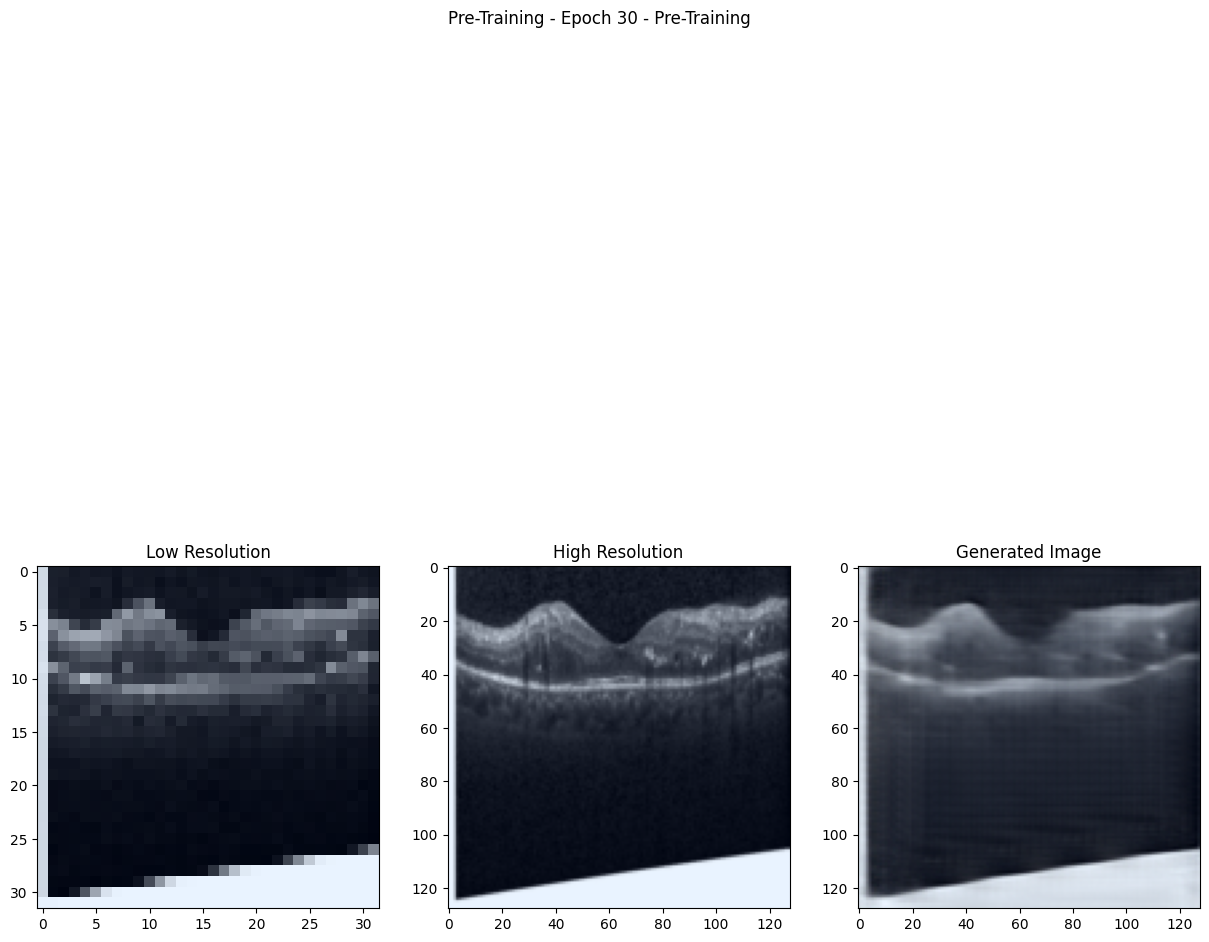

Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.21it/s, Gen loss=0.0235]


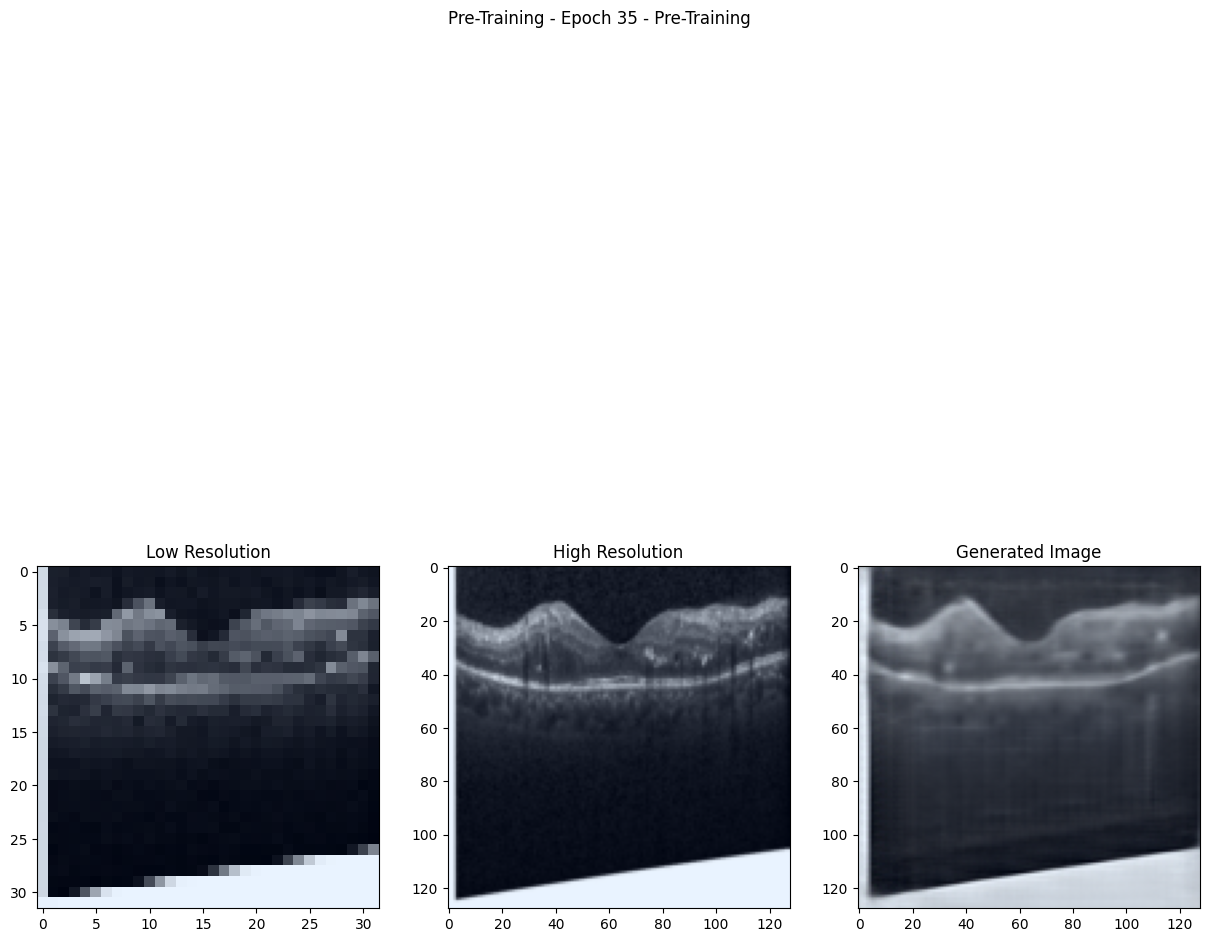

Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.21it/s, Gen loss=0.0215]


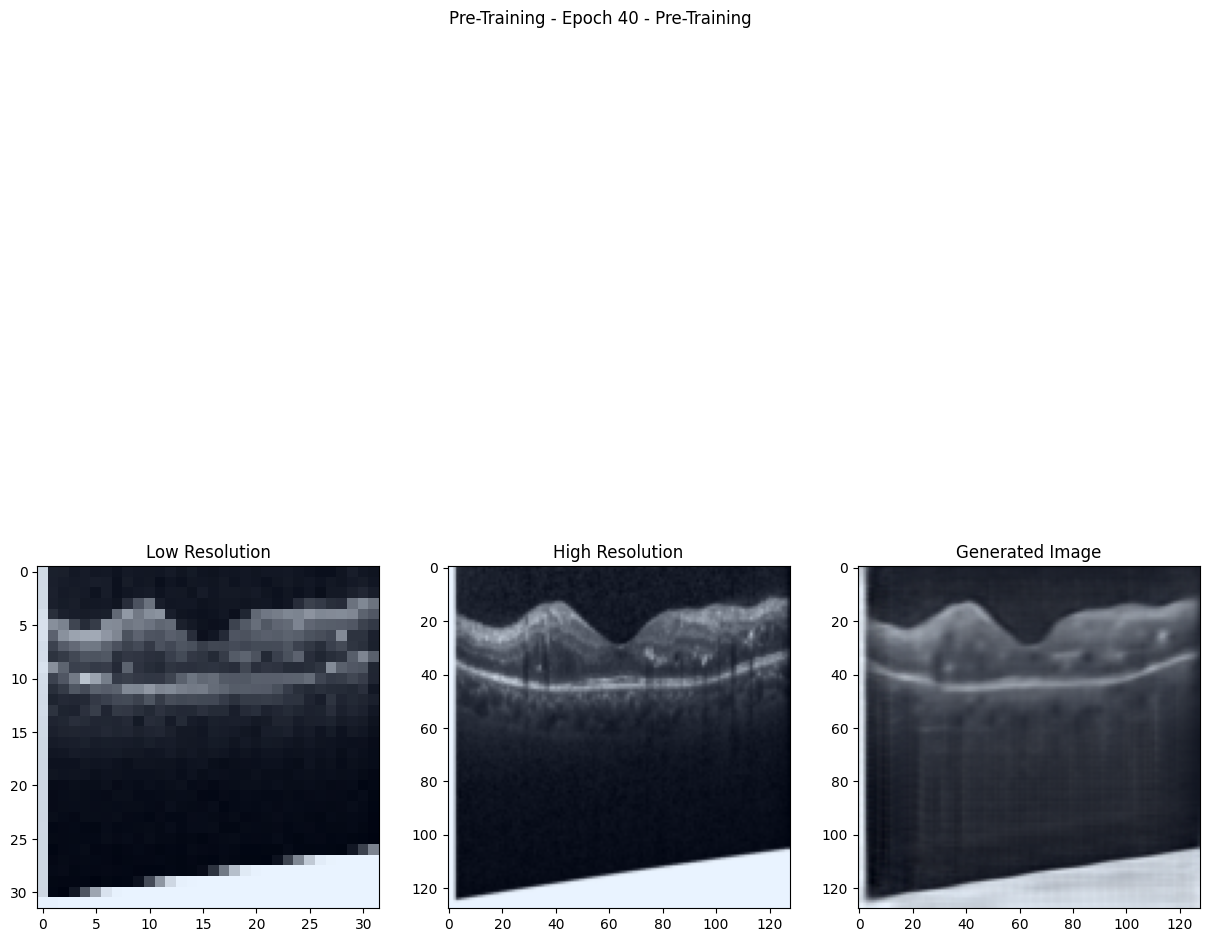

Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.22it/s, Gen loss=0.0200]


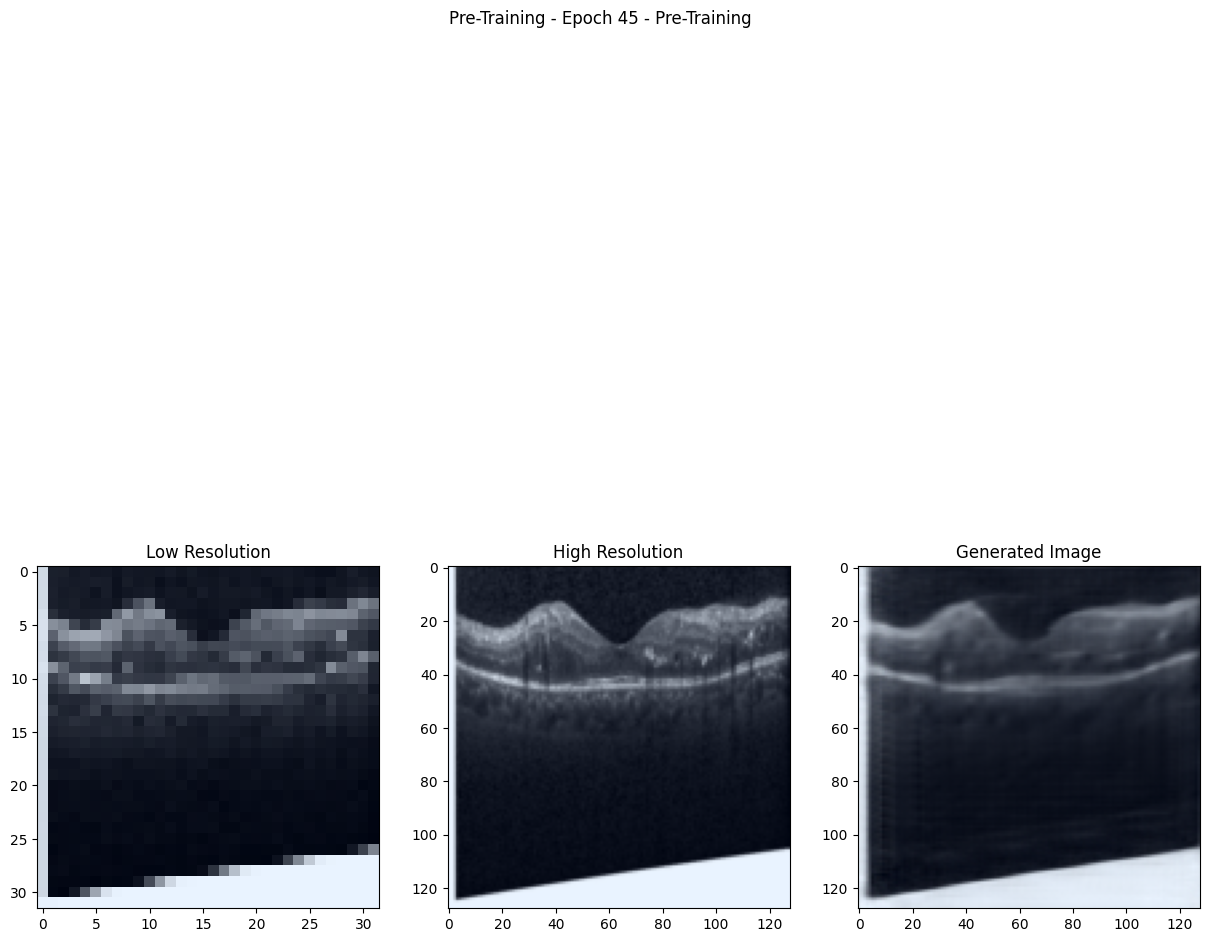

Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:04<00:00,  9.23it/s, Gen loss=0.0198]
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-avq8mwxo'
Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████| 598/598 [01:05<00:00,  9.18it/s, Gen loss=0.0194]


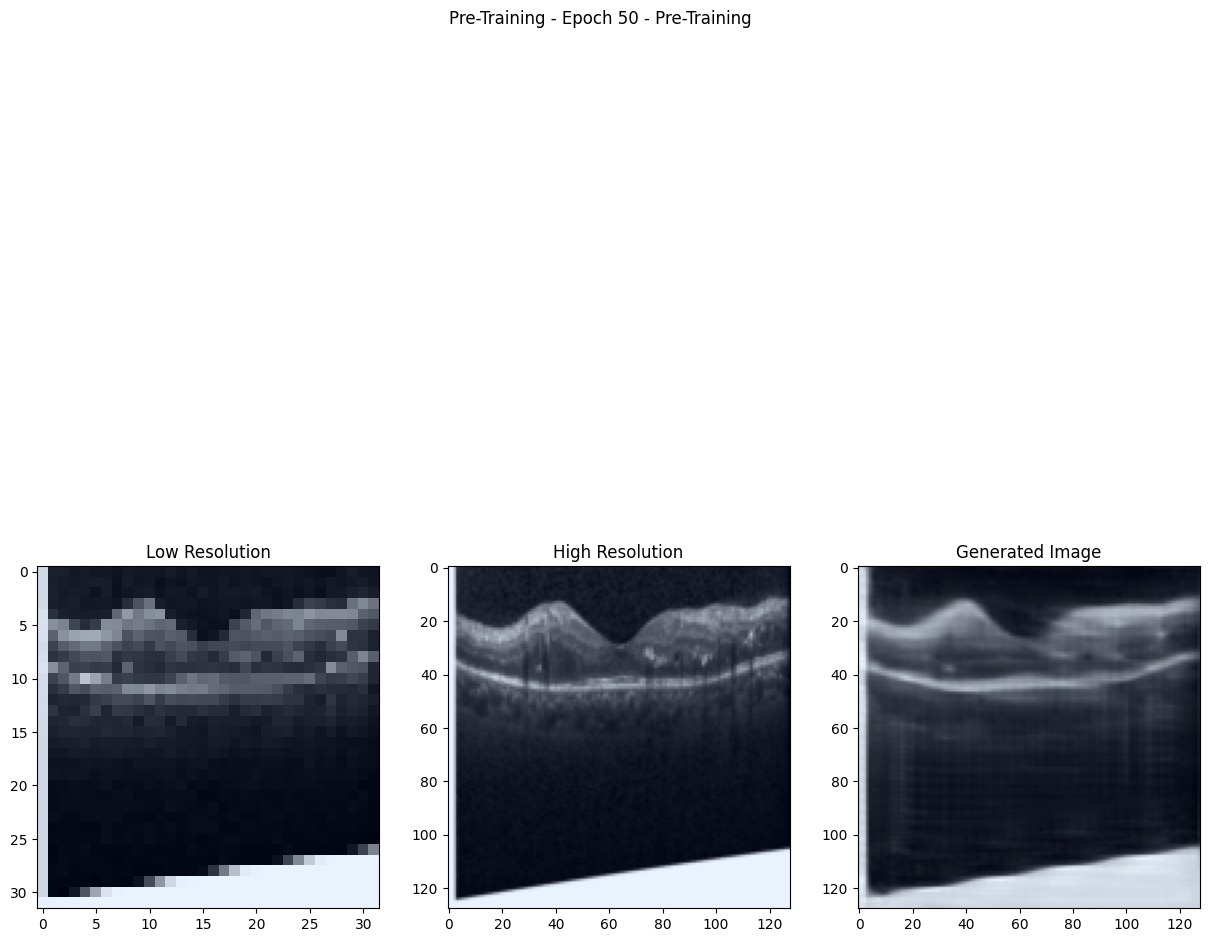

Starting adversarial training phase...


Epoch 1/100:   1%|█▎                                                                                                  | 8/598 [00:16<18:59,  1.93s/it]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-29z_7dsi'
Epoch 1/100:  13%|███████▊                                                      | 75/598 [02:20<16:27,  1.89s/it, Gen loss=0.0014, Discr loss=50.0001]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-rlwrx5sl'
Epoch 1/100:  75%|█████████████████████████████████████████████▊               | 449/598 [14:05<04:34,  1.84s/it, Gen loss=0.0012, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-0mvhfr86'
Epoch 1/100:  76%|██████████████████████████████████████████████▏              | 453/598 [14:12<

  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-290f6jxf'
Epoch 2/100:  13%|███████▉                                                      | 77/598 [02:23<15:54,  1.83s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-4p

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-tdfsnwf_'
Epoch 2/100:  55%|█████████████████████████████████▎                           | 327/598 [10:02<08:21,  1.85s/it, Gen loss=0.0011, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
OSError: [Errno 39] Directory not empty: '/tmp/pymp-f31zrm93'
Epoch 3/100:  69%|██████████████████████████████████████████                   | 412/598 [12:43<05:59,  1.93s/it, Gen loss=0.0011, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-61hzo76q'
Epoch 3/100:  70%|██████████████████████████████████████████▋          

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-fvfq51zc'
Epoch 4/100:  26%|███████████████▉                                             | 156/598 [04:49<13:20,  1.81s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

OSError: [Errno 39] Directory not empty: '/tmp/pymp-uydok_gc'
Epoch 5/100:  15%|█████████                                                     | 88/598 [02:45<15:43,  1.85s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ynzlh0g2'
Epoch 5/100:  16%|█████████▉                                                    | 96/598 [03:00<15:04,  1.80s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent ca

  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-8lo6jmhb'
Epoch 5/100:  72%|███████████████████████████████████████████▋                 | 428/598 [13:12<05:13,  1.84s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-j1

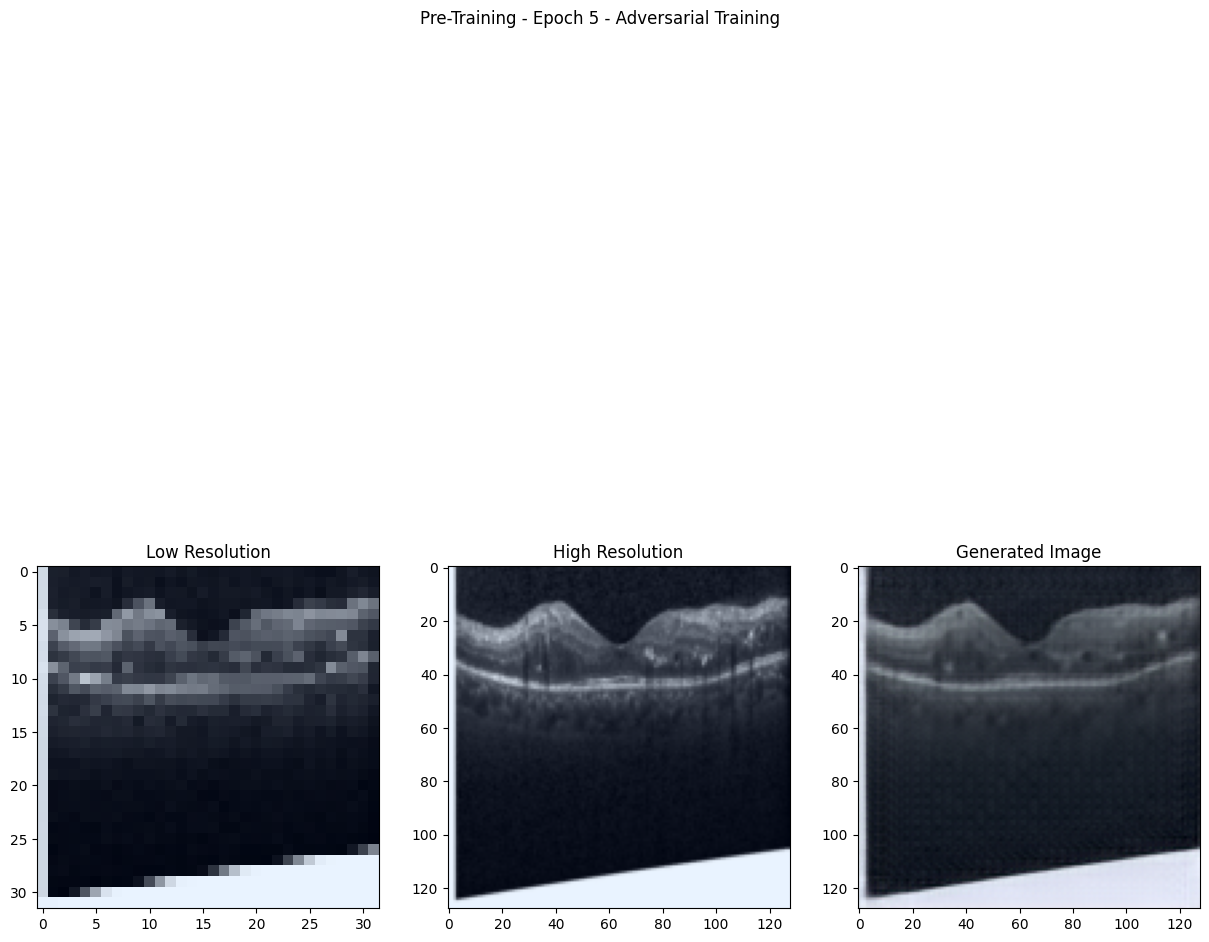

Epoch 6/100:   0%|                                                                                                            | 0/598 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-dljwj90r'
Epoch 6/100:   6%|███▋                                                          | 35/598 [01:05<17:13,  1.84s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-a01v_mc5'
Epoch 6/100:  61%|█████████████████████████████████████▎                       | 366/598 [11:29<07:23,  1.91s/it, Gen loss=0.0011, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-lf879pk2'
Epoch 6/100:  63%|██████████████████████████████████████▌                      | 378/598 [11:52<

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-43tj5o0r'
Epoch 7/100:   9%|█████▊                                                        | 56/598 [01:44<16:04,  1.78s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-6nyl7v3c'
Epoch 7/100:  14%|████████▋                                                     | 84/598 [02:35<

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ik6hu15j'
Epoch 7/100:  47%|████████████████████████████▊                                | 282/598 [08:42<09:33,  1.82s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-clfzojcw'
Epoch 7/100:  51%|██████████████████████████████▊                              | 302/598 [09:19<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ndz6tky1'
Epoch 8/100:  17%|██████████▌                                                  | 103/598 [03:09<15:17,  1.85s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-jbn8auhh'
Epoch 8/100:  45%|███████████████████████████▋                                 | 272/598 [08:21<09:55,  1.83s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-8915vfj5'
Epoch 9/100:  38%|███████████████████████                                      | 226/598 [06:59<11:25,  1.84s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-l9lyo5ay'
Epoch 9/100:  89%|██████████████████████████████████████████████████████▍      | 534/598 [16:28<01:58,  1.85s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

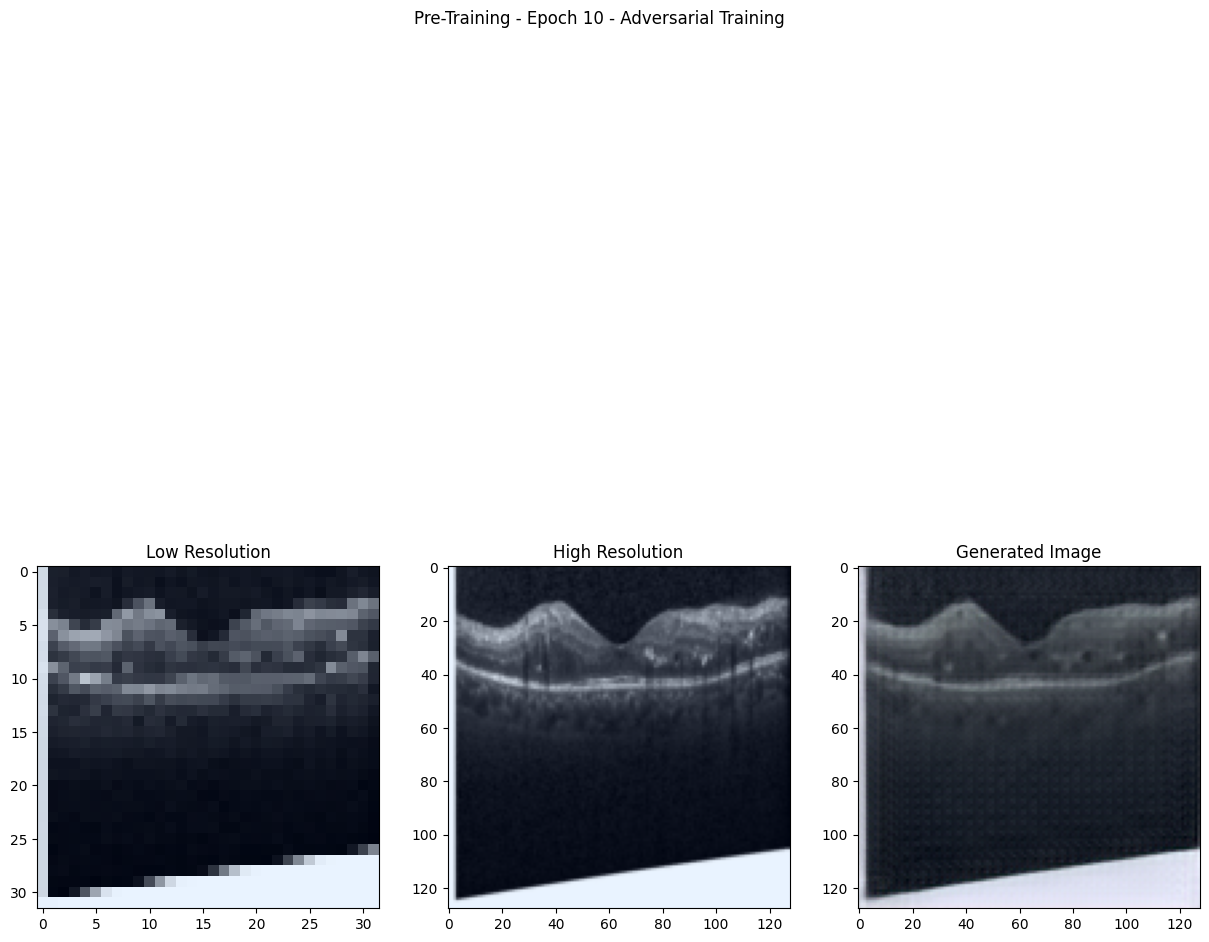

Epoch 11/100:   2%|█▎                                                           | 13/598 [00:25<18:38,  1.91s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-kgb7jkib'
Epoch 11/100:   4%|██▌                                                          | 25/598 [00:48<17:53,  1.87s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

Epoch 11/100:  36%|█████████████████████▍                                      | 214/598 [06:38<11:43,  1.83s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-om1_zd33'
Epoch 11/100:  52%|███████████████████████████████▏                            | 311/598 [09:38<08:41,  1.82s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-gzswzmp7'
Epoch 12/100:  12%|███████▍                                                     | 73/598 [02:16<16:40,  1.90s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-arhbm2dp'
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728,

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-xscyfepa'
Epoch 12/100:  71%|██████████████████████████████████████████▌                 | 424/598 [12:59<05:02,  1.74s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-q6q_bw4p'
Epoch 14/100:  59%|███████████████████████████████████▍                        | 353/598 [10:54<07:46,  1.90s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

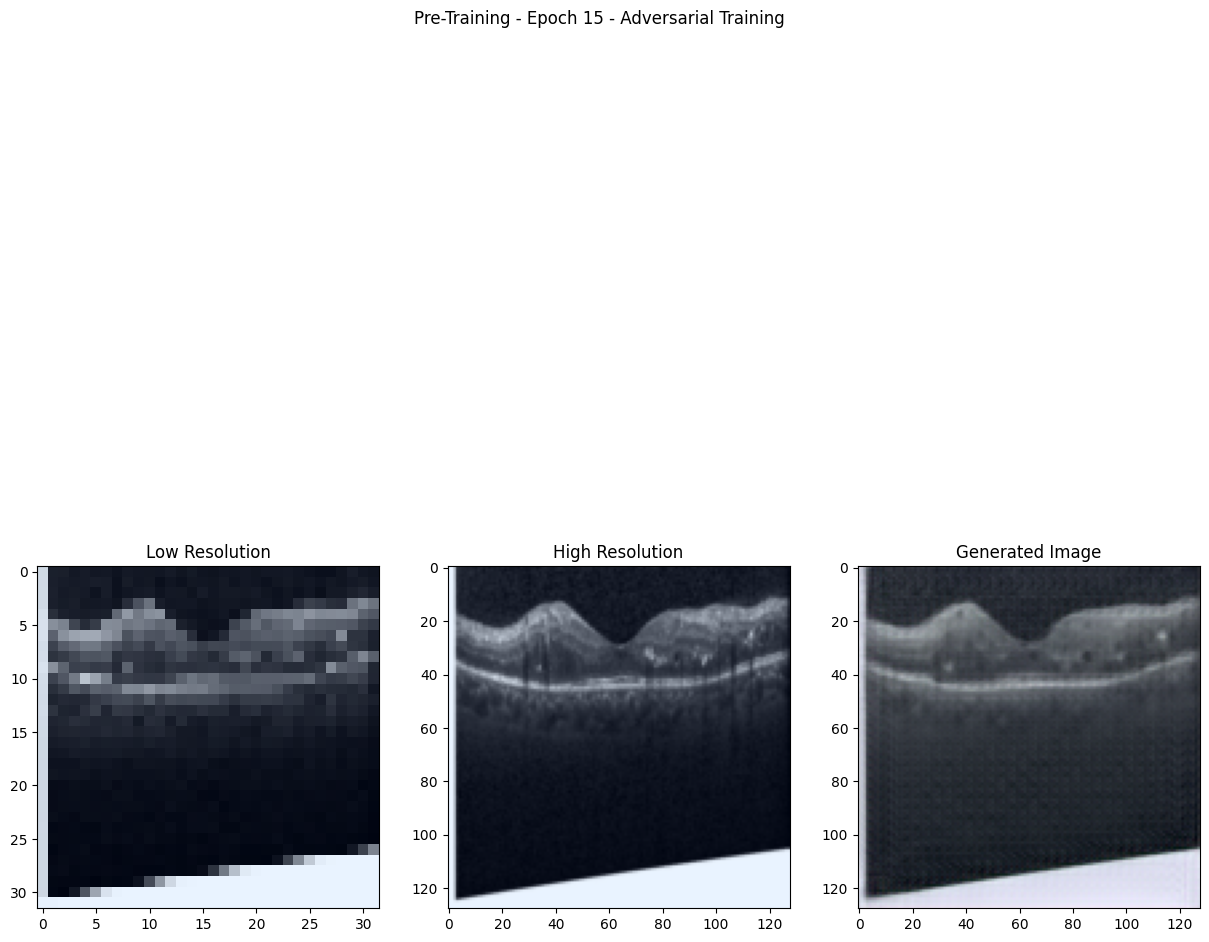

Epoch 16/100:   1%|█▎                                                                                                 | 8/598 [00:16<19:03,  1.94s/it]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-v1e18qfb'
Epoch 16/100:  23%|█████████████▋                                              | 136/598 [04:14<14:26,  1.88s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-abp_3jk3'
Epoch 16/100:  52%|███████████████████████████████▎                            | 312/598 [09:41<08:59,  1.89s/it, Gen loss=0.0010, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-0609o8ef'
Epoch 16/100:  59%|███████████████████████████████████▍                        | 353/598 [10:58<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ntlg9vn8'
Epoch 17/100:  17%|██████████▍                                                 | 104/598 [03:13<15:07,  1.84s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-l1il9_6i'
Epoch 18/100:  22%|█████████████▏                                              | 131/598 [04:05<14:39,  1.88s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-uxyti7h9'
Epoch 18/100:  61%|████████████████████████████████████▌                       | 364/598 [11:14<07:03,  1.81s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "

Epoch 19/100:  60%|████████████████████████████████████                        | 359/598 [11:04<07:18,  1.83s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-6pgx02lr'
Epoch 19/100:  65%|██████████████████████████████████████▊                     | 387/598 [11:57<06:50,  1.95s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ds_ijkc0'
Epoch 20/100:   7%|████▏                                                        | 41/598 [01:16<17:42,  1.91s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-phjdbbe6'
Epoch 20/100:  66%|███████████████████████████████████████▊                    | 397/598 [12:10<06:04,  1.81s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

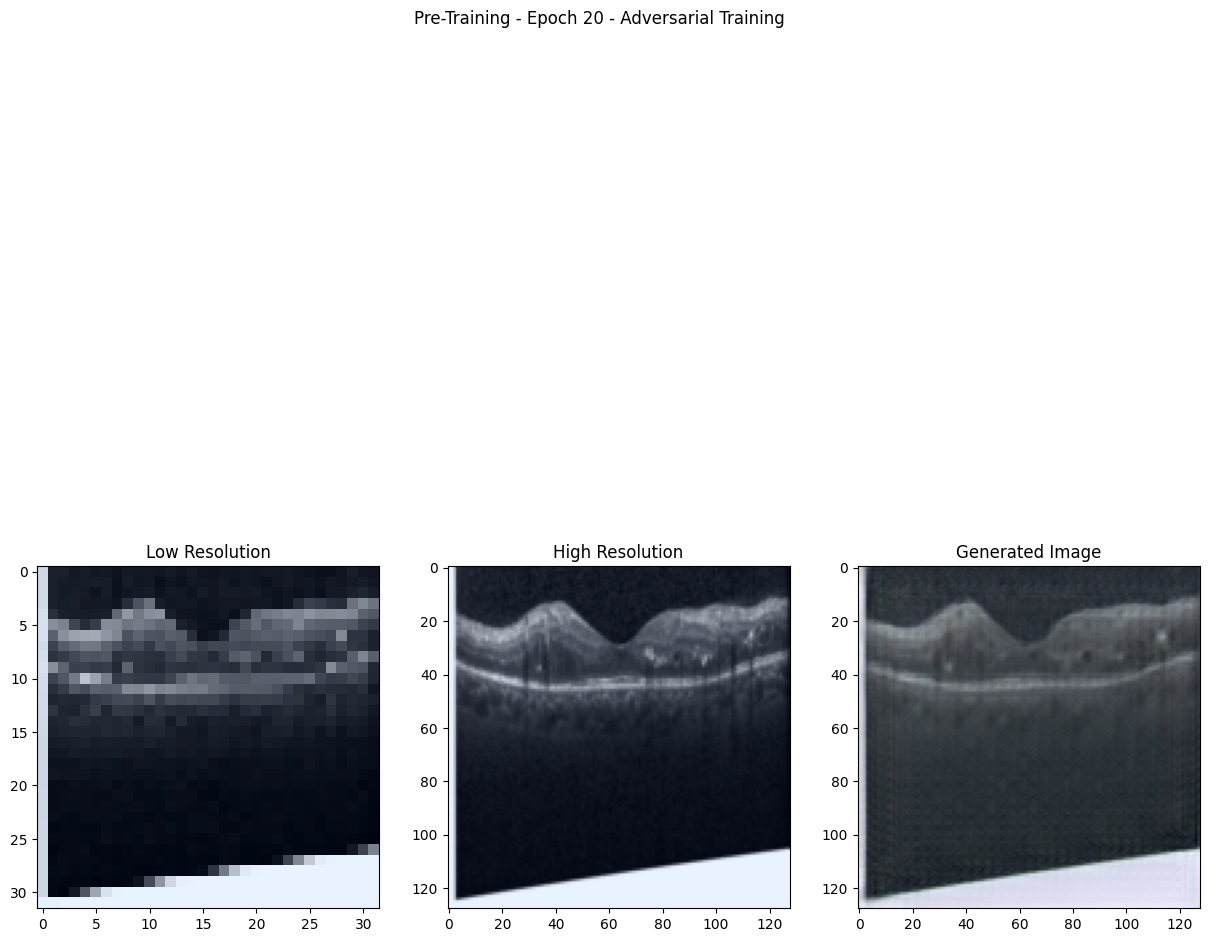

Epoch 21/100:   3%|█▋                                                           | 16/598 [00:31<18:33,  1.91s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-3ym9nyq2'
Epoch 21/100:  21%|████████████▍                                               | 124/598 [03:51<14:06,  1.79s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-g5krgo2r'
Epoch 21/100:  86%|███████████████████████████████████████████████████▎        | 512/598 [15:45<02:41,  1.88s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-p7ru2901'
Epoch 21/100:  93%|███████████████████████████████████████████████████████▌    | 554/598 [17:02<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-nidwkpog'
Epoch 22/100:  32%|██████████████████▉                                         | 189/598 [05:51<12:45,  1.87s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-alkt0eel'
Epoch 22/100:  65%|███████████████████████████████████████                     | 389/598 [12:02<06:48,  1.95s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

OSError: [Errno 39] Directory not empty: '/tmp/pymp-tjphn2a_'
Epoch 23/100:  14%|████████▋                                                    | 85/598 [02:38<16:13,  1.90s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-95jysw02'
Epoch 23/100:  18%|██████████▊                                                 | 108/598 [03:20<15:03,  1.84s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent ca

  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-s5uplmve'
Epoch 23/100:  75%|████████████████████████████████████████████▉               | 448/598 [13:48<04:38,  1.86s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-9o

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-9xzi_6ef'
Epoch 24/100:   9%|█████▏                                                       | 51/598 [01:35<17:11,  1.89s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-hlhgqy4q'
Epoch 24/100:  46%|███████████████████████████▊                                | 277/598 [08:35<09:41,  1.81s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-it33r07g'
Epoch 25/100:  47%|███████████████████████████▉                                | 279/598 [08:33<09:24,  1.77s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-6_td_m0s'
Epoch 25/100:  47%|████████████████████████████▍                               | 284/598 [08:42<

  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-qva1j4o7'
Epoch 25/100:  84%|██████████████████████████████████████████████████▋         | 505/598 [15:32<02:58,  1.92s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-r3

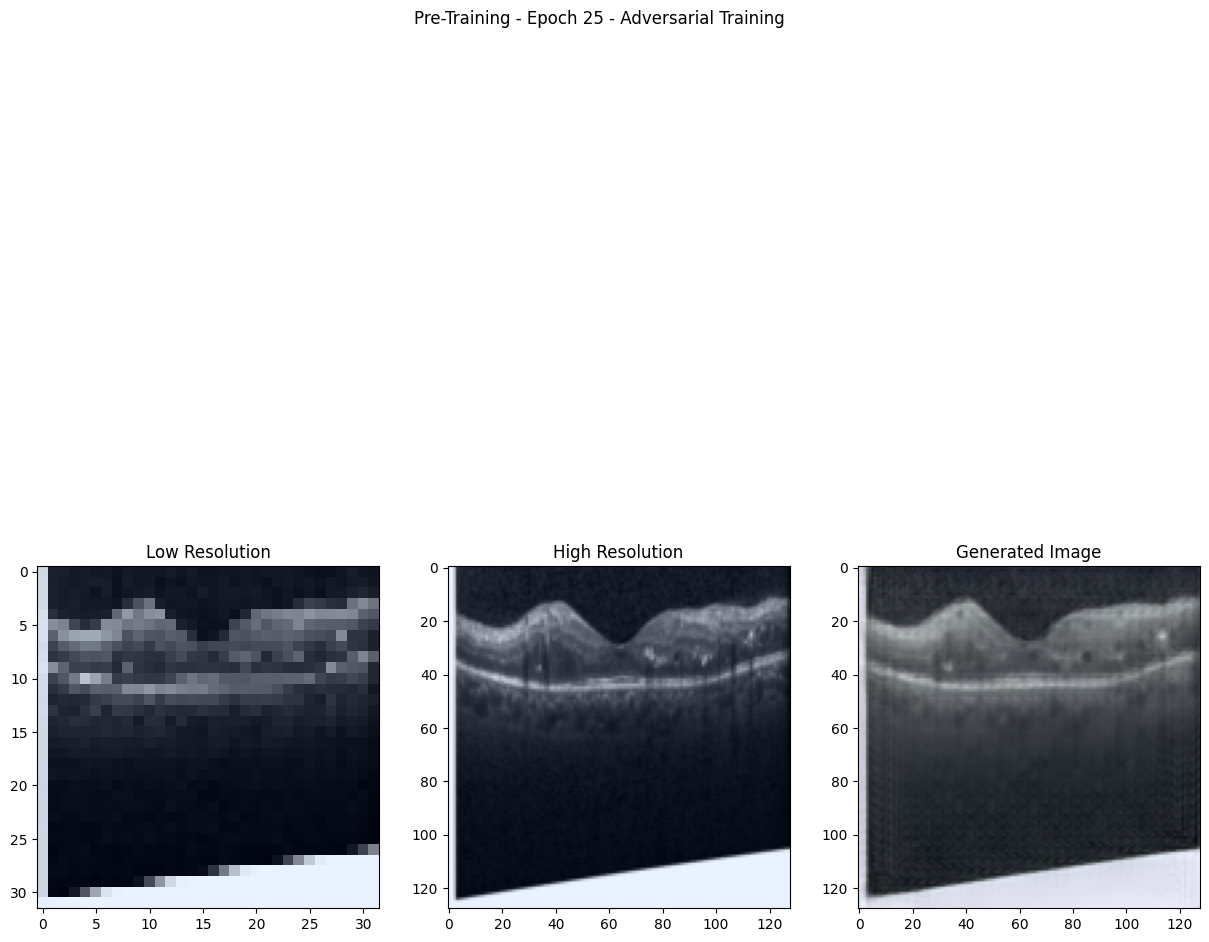

Epoch 26/100:   8%|████▉                                                        | 49/598 [01:31<16:31,  1.81s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-iwrnecax'
Epoch 26/100:  19%|███████████▏                                                | 112/598 [03:35<14:40,  1.81s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-n20dx43o'
Epoch 26/100:  82%|████████████████████████████████████████████████▉           | 488/598 [15:08<03:27,  1.89s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-sebe46cw'
Epoch 26/100:  94%|████████████████████████████████████████████████████████▌   | 564/598 [17:29<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-34mo6q23'
Epoch 27/100:  23%|█████████████▌                                              | 135/598 [04:11<14:22,  1.86s/it, Gen loss=0.0009, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-8e9qsmmo'
Epoch 28/100:  57%|██████████████████████████████████                          | 340/598 [10:27<08:06,  1.89s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-90uz1ver'
Epoch 29/100:   4%|██▍                                                          | 24/598 [00:46<17:30,  1.83s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

OSError: [Errno 39] Directory not empty: '/tmp/pymp-_zkcs0s0'
Epoch 29/100:  69%|█████████████████████████████████████████▌                  | 414/598 [12:49<05:33,  1.81s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-o0s2o0pn'
Epoch 29/100:  73%|████████████████████████████████████████████                | 439/598 [13:35<04:35,  1.73s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent ca

  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-597b0yia'
Epoch 30/100:  21%|████████████▍                                               | 124/598 [03:50<14:38,  1.85s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/s

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-2hd7nmvn'
Epoch 30/100:  68%|████████████████████████████████████████▊                   | 407/598 [12:32<05:59,  1.88s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

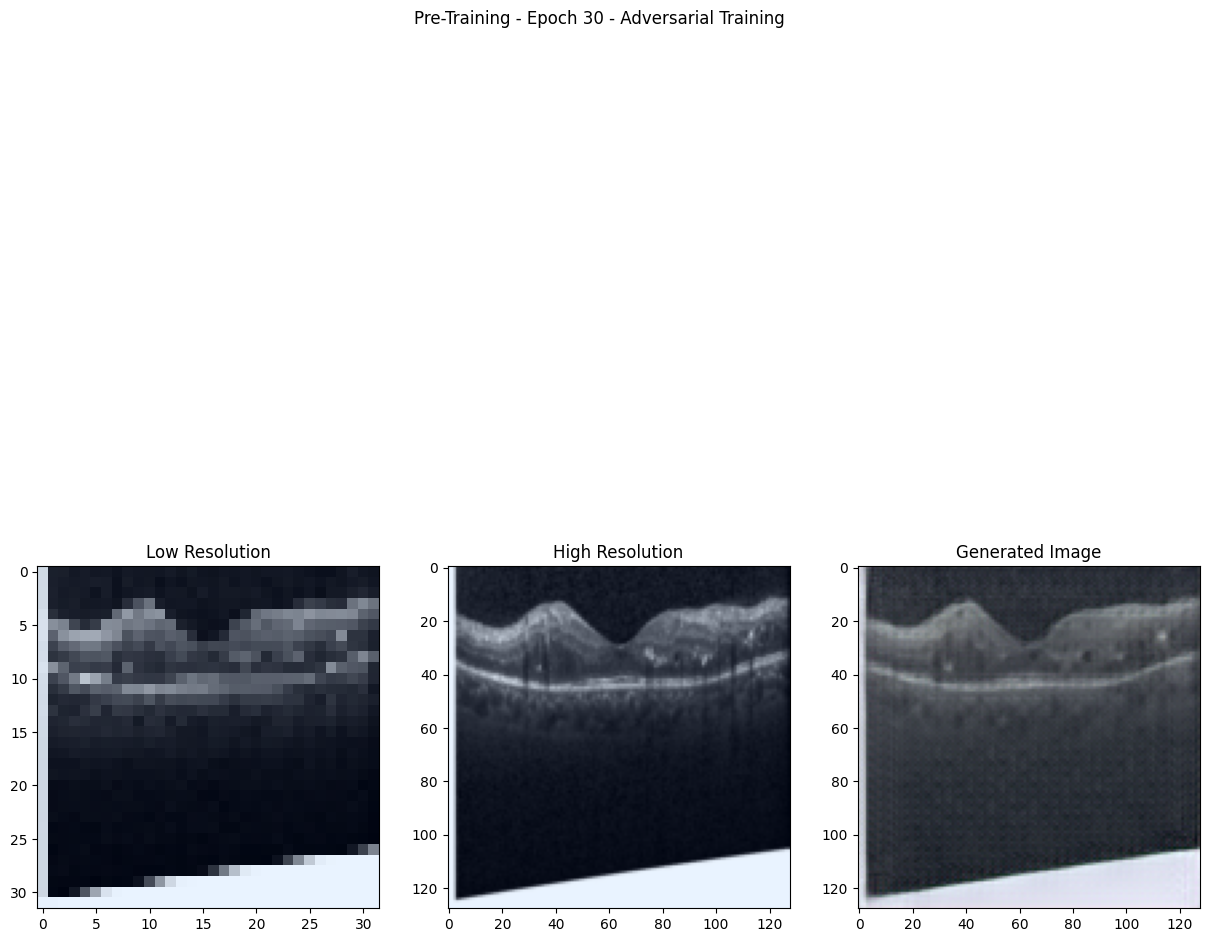

Epoch 31/100:   9%|█████▎                                                       | 52/598 [01:38<16:48,  1.85s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-r_zkldi4'
Epoch 31/100:  21%|████████████▊                                               | 128/598 [03:59<14:18,  1.83s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py"

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-lv9kxl7u'
Epoch 32/100:   9%|█████▌                                                       | 55/598 [02:02<19:18,  2.13s/it, Gen loss=0.0007, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-79rn4t_w'
Epoch 32/100:  30%|█████████████████▊                                          | 177/598 [06:21<

  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-eqboudo1'
Epoch 33/100:  95%|█████████████████████████████████████████████████████████▏  | 570/598 [21:00<01:00,  2.15s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-tiuvsy9r'
Epoch 34/100:   9%|█████▋                                                       | 56/598 [02:05<

  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-35mcml2v'
Epoch 34/100:  43%|██████████████████████████                                  | 260/598 [09:07<11:17,  2.01s/it, Gen loss=0.0007, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  F

OSError: [Errno 39] Directory not empty: '/tmp/pymp-x5tbdtdn'
Epoch 35/100:  21%|████████████▋                                               | 127/598 [04:13<15:40,  2.00s/it, Gen loss=0.0007, Discr loss=50.0000]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 730, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 728, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-csop3xb9'
Epoch 35/100:  23%|█████████████▋                                              | 136/598 [04:31<15:03,  1.96s/it, Gen loss=0.0008, Discr loss=50.0000]Traceback (most recent ca

In [ ]:
from tqdm import tqdm
# Pre-training phase
print("Starting pre-training phase...")
for epoch in range(50):
    generator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{50}",ncols=bar_width)
    
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Compute the loss and update the parameters
        generator_loss_value = pretrain_generator_loss(sr_images, hr_images)
        generator_optimizer.zero_grad()
        generator_loss_value.backward(retain_graph=True)
        generator_optimizer.step()

        pretrain_loss.append(generator_loss_value.item())
        
        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}"})
        pbar.update()

    pbar.close()
    
    
    # Save the generator model every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_model_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize_images(lr_images[0], hr_images[0], sr_images[0], "Pre-Training", epoch+1, True)

# Adversarial training phase
print("Starting adversarial training phase...")
                         
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", ncols=bar_width)
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Train the discriminator
        discriminator_optimizer.zero_grad()

        real_labels = torch.ones(hr_images.size(0), 1).to(device)
        fake_labels = torch.zeros(hr_images.size(0), 1).to(device)

        discriminator_real_output = discriminator(hr_images)
        discriminator_fake_output = discriminator(sr_images)

        discriminator_loss_fn = DiscriminatorLoss().to(device)

        discriminator_real_loss = discriminator_loss_fn(discriminator_real_output, real_labels)
        discriminator_fake_loss = discriminator_loss_fn(discriminator_fake_output, fake_labels)

        discriminator_loss_value = discriminator_real_loss + discriminator_fake_loss
        discriminator_loss_value.backward()
        discriminator_optimizer.step()


        # Train the generator
        generator_optimizer.zero_grad()
        sr_images = generator(lr_images)
        discriminator_fake_output = discriminator(sr_images)

        generator_loss_value = generator_loss_fn(sr_images, hr_images, discriminator_fake_output)
        generator_loss_value.backward()
        generator_optimizer.step()

        discriminator_loss_history.append(discriminator_loss_value.item())
        generator_loss_history.append(generator_loss_value.item()) # moved here


        # Get new data from the train_loader
        lr_images, hr_images, _ = next(iter(train_loader))
        lr_images = lr_images.detach()
        hr_images = hr_images.detach()
        
        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}", "Discr loss": f"{discriminator_loss_value.item():.4f}"})
        pbar.update()



    pbar.close()
    # Save the generator and discriminator models every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_epoch_{epoch+1}.pt")
        torch.save(discriminator.state_dict(), f"./models/discriminator_epoch_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize_images(lr_images[0], hr_images[0], sr_images[0], "Adversarial Training", epoch+1, True)


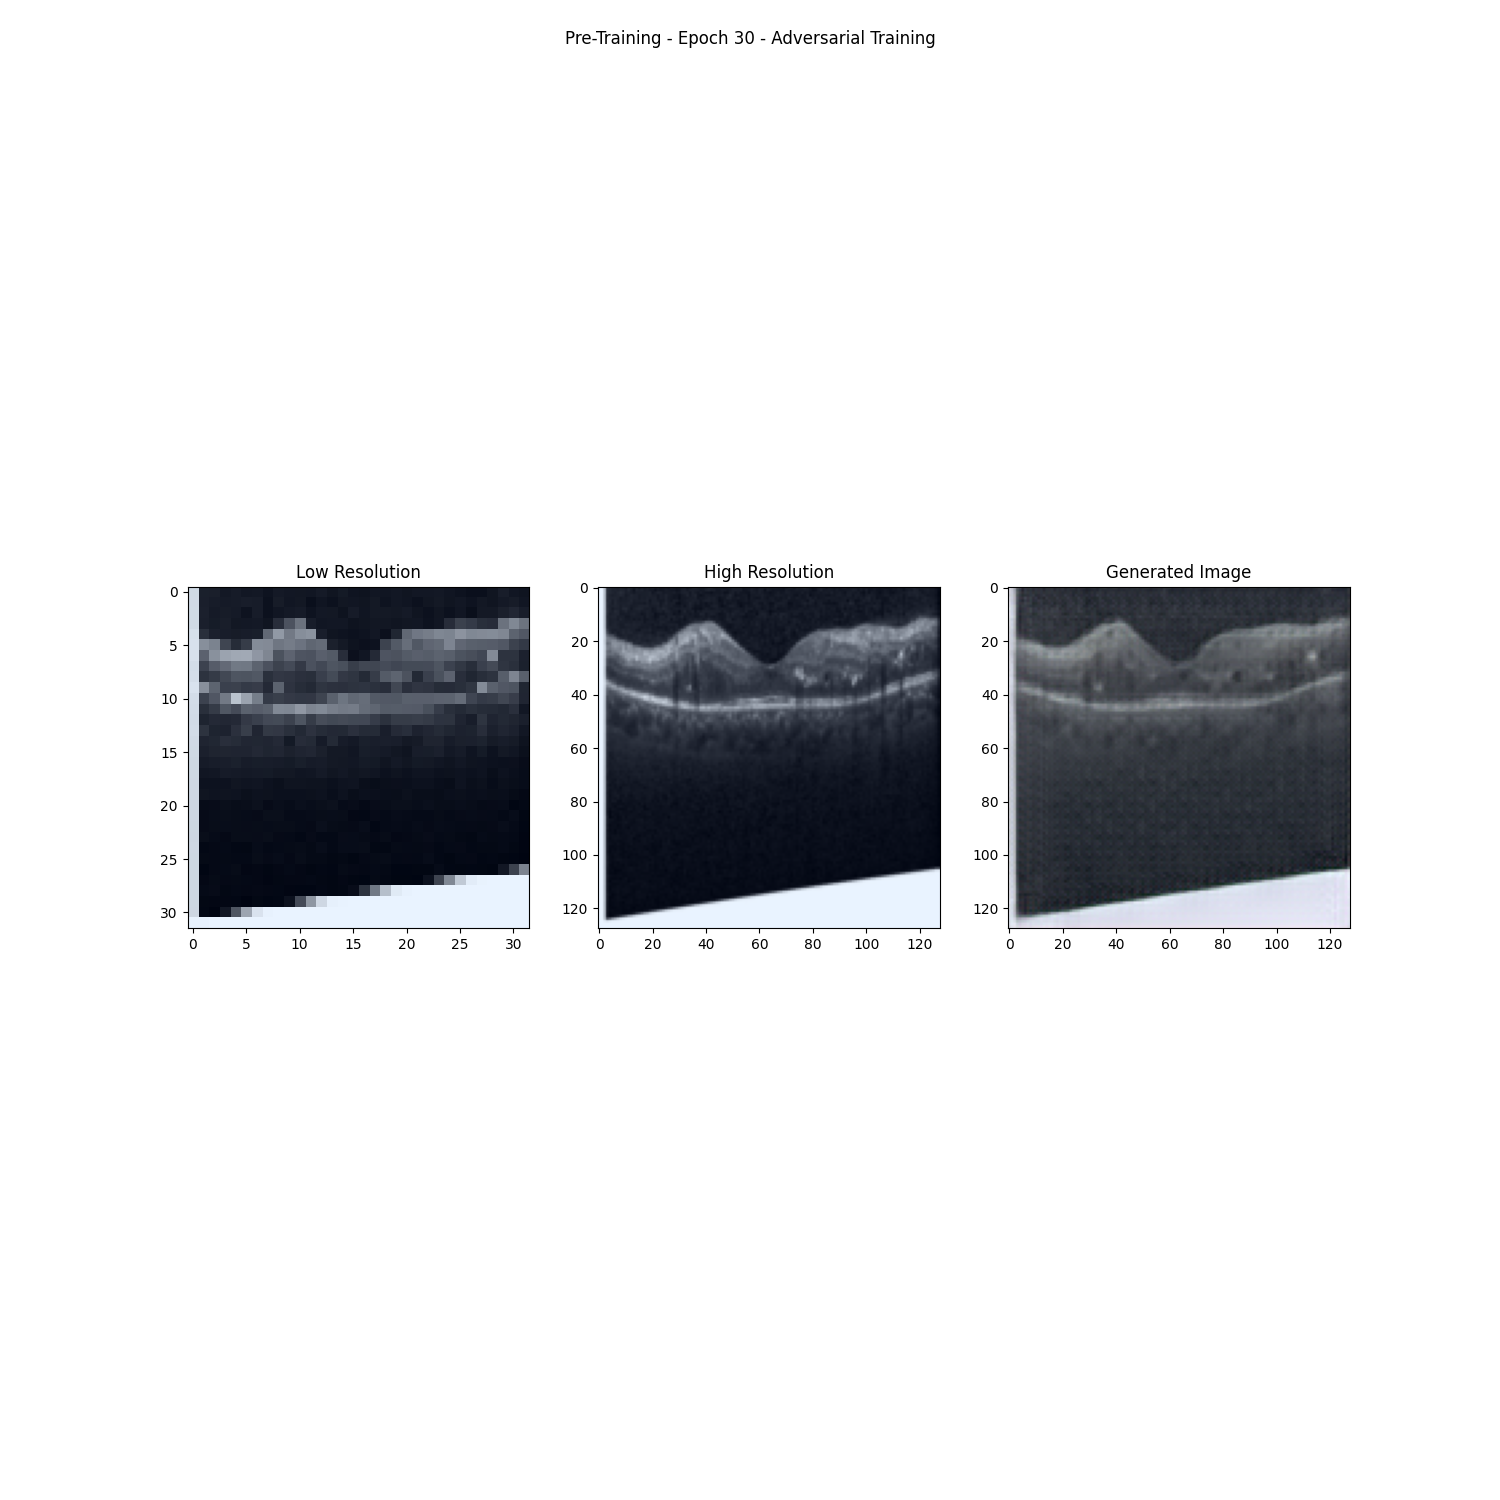

In [1]:
from IPython.display import Image

Image(filename='./output/epoch_30_Adversarial Training.png')
#last epoch

##### 